In [ ]:
# %matplotlib inline
import torchvision
import torchvision.datasets as dset
import torchvision.transforms as transforms
from torch.utils.data import DataLoader,Dataset
import matplotlib.pyplot as plt
import torchvision.utils
import numpy as np
import random
from PIL import Image
import torch
from torch.autograd import Variable
import PIL.ImageOps    
import torch.nn as nn
from torch import optim
import torch.nn.functional as F
import os
from torch.utils import data
import pandas as pd
from random import randint
from siamese_new_classes import siamese_Dataset_no_mode

os.environ['CUDA_VISIBLE_DEVICES']='1' # pick GPU to use
use_cuda = torch.cuda.is_available()
device = torch.device("cuda:1" if use_cuda else "cpu")

def imshow(img,text=None,should_save=False):
    npimg = img.numpy()
    plt.axis("off")
    if text:
        plt.text(75, 8, text, style='italic',fontweight='bold',
            bbox={'facecolor':'white', 'alpha':0.8, 'pad':10})
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()    

def show_plot(iteration,loss):
    plt.plot(iteration,loss)
    plt.show()

In [ ]:
class Identity(nn.Module):
    def __init__(self):
        super(Identity, self).__init__()
        
    def forward(self, x):
        return x




class PretrainedNet(nn.Module):
    """
    Siamese neural network
    Modified from: https://hackernoon.com/facial-similarity-with-siamese-networks-in-pytorch-9642aa9db2f7
    Siamese ResNet-101 from Pytorch library
    """
    def __init__(self):
        super(PretrainedNet, self).__init__()
        self.cnn = torchvision.models.resnet18()
        self.cnn.fc = Identity()
        #se
        #for name, para in self.cnn1.named_parameters():
        #    if para.requires_grad:
        #        print (name)
        #alex_load.classifier[4] = nn.Linear(in_features = alex_load.classifier[1].out_features, out_features = 1000, bias = True)
        #self.cnn1.classifier[6] = nn.Linear(in_features = self.cnn1.classifier[4].out_features, out_features = 2, bias = True)
        
        
        #vgg16
        
        self.vgg16 = torchvision.models.vgg16_bn(weights=torchvision.models.VGG16_BN_Weights.DEFAULT)
        
        self.vgg16.classifier[0] = nn.Linear(in_features = 25088, out_features = 2048)
        self.vgg16.classifier[3] = nn.Linear(in_features = 2048, out_features = 1024)
        self.vgg16.classifier[6] = nn.Linear(in_features = 1024, out_features = 512)

        # LAST 3 CNN LAYERS / LAST BLOCK OF LAYERS ARE UNFROZEN
        #CONV-CONV-POOL - CONV-CONV-POOL - CONV-CONV-CONV-POOL - CONV-CONV-CONV-POOL
        #for param in self.vgg16.features[0:22].parameters():
        #      param.requires_grad = False
        
        #for name, param in vgg16.named_parameters():
        #    print(f'Parameter name: {name}, Requires gradient: {param.requires_grad}')
    def forward_once(self, x):
        output = self.cnn(x)
        return output

    def forward(self, input1, input2):
        output1 = self.forward_once(input1)
        output2 = self.forward_once(input2)
        return output1, output2


#x = torch.randn(1, 3, 224, 224)
#output = vgg(x)
#print(output.shape)

In [ ]:
net = PretrainedNet().cuda()

class TestConfig():
    training_table = pd.read_csv('/mnt/recsys/daniel/datasets/ffhq_gan_generated_siamese_training/full_img_folders/csv_files/train_file.csv')
    testing_table = pd.read_csv('/mnt/recsys/daniel/datasets/ffhq_gan_generated_siamese_training/full_img_folders/csv_files/test_file.csv')
    image_dir = '/mnt/recsys/daniel/datasets/ffhq_gan_generated_siamese_training/full_img_folders'

In [7]:

checkpoints_dir = "./ckpt"
test_epoch = 29

#test_model = SiameseNetworkbasic().cuda()
test_model = PretrainedNet().cuda()
test_model.load_state_dict(torch.load(checkpoints_dir + "/base_model_epoch{}.pth".format(test_epoch)))


test_transforms = transforms.Compose([ # pixel crop
    transforms.ToTensor()
])



testing_siamese_dataset = siamese_Dataset_no_mode(patient_table = TestConfig.training_table,
                                          image_dir = TestConfig.image_dir,
                                          #scores_csv_file = TestConfig.scores_csv_file,
                                          transform = test_transforms)

test_dataloader = torch.utils.data.DataLoader(testing_siamese_dataset,
                                                  batch_size=1,
                                                  shuffle=True,
                                                  num_workers=0)

dataiter = iter(test_dataloader)

scores_list = []
dissimilarity_score = []
patient_id = []
labels = [] 
x_axis = [x for x in range(len(test_dataloader))]

euclidean_distance_threshold = 0.9871837895323841
print(len(test_dataloader))
countsa = 0
for test_cnt in range(len(test_dataloader)):
    x_0, x_1, label , n , m= next(dataiter)
    #print (x_0.shape)
    concatenated = torch.cat((x_0,x_1),0)
    output1,output2 = net(Variable(x_0).cuda(),Variable(x_1).cuda())
    euclidean_distance = F.pairwise_distance(output1, output2)
    testing_label = euclidean_distance > euclidean_distance_threshold
    equals = testing_label.int().detach().cpu().numpy().flatten() == label.int().cpu().numpy()
    
    if equals:
        countsa +=1
    else:
        print (euclidean_distance.item(), "--------", n[0], m[0], label.int().cpu().numpy())

print ('Acc:{}'.format(countsa/len(test_dataloader)))
'''
dissimilarity_score = np.array(dissimilarity_score).astype(np.float64)
scores_list = np.array(scores_list).astype(np.float64)

plt.scatter(scores_list, dissimilarity_score)
a, b = np.polyfit(scores_list, dissimilarity_score,  1)
plt.plot(scores_list, a*scores_list+b, 'r-') 
plt.show()
'''

686
0.9883970022201538 -------- 65629_truth.png 65629_out.png [0]
1.2007609605789185 -------- 62183_truth.png 62183_out.png [0]
0.9875524044036865 -------- 67777_truth.png 67777_out.png [0]
1.143293023109436 -------- 61758_truth.png 61758_out.png [0]
1.0778836011886597 -------- 68744_truth.png 68744_out.png [0]
1.1228784322738647 -------- 69766_truth.png 69766_out.png [0]
1.1732643842697144 -------- 69972_truth.png 69972_out.png [0]
1.0193212032318115 -------- 66769_truth.png 66769_out.png [0]
1.1228784322738647 -------- 69766_truth.png 69766_out.png [0]
1.0224939584732056 -------- 68236_truth.png 68236_out.png [0]
1.14412522315979 -------- 64526_truth.png 64526_out.png [0]
0.9991796016693115 -------- 65399_truth.png 65399_out.png [0]
1.0196892023086548 -------- 66742_truth.png 66742_out.png [0]
1.0096402168273926 -------- 66279_truth.png 66279_out.png [0]
1.025452971458435 -------- 67139_truth.png 67139_out.png [0]
1.1228784322738647 -------- 69766_truth.png 69766_out.png [0]
1.200760

"\ndissimilarity_score = np.array(dissimilarity_score).astype(np.float64)\nscores_list = np.array(scores_list).astype(np.float64)\n\nplt.scatter(scores_list, dissimilarity_score)\na, b = np.polyfit(scores_list, dissimilarity_score,  1)\nplt.plot(scores_list, a*scores_list+b, 'r-') \nplt.show()\n"

In [6]:
n[0]

'63897_truth.png'

In [29]:
import io
import base64
import pandas as pd
from dash import Dash, dcc, html, Input, Output, no_update, callback
import plotly.express as px
import numpy as np
from PIL import Image

import plotly as py
import plotly.graph_objs as go
from plotly.offline import download_plotlyjs, init_notebook_mode, plot, iplot

df = pd.DataFrame(dict( doctor_score = scores_list, pred_value = dissimilarity_score, patient_name= patient_id, labels = labels))

grad, inter = np.polyfit(df["doctor_score"].tolist(), df["pred_value"].tolist(), 1)
x_val = list(np.arange(1, 5.1, 0.10))
y_val = [(element * grad) +inter for element in x]


cluster0 = df[df["labels"] == 1]

init_notebook_mode(connected=True)

trace1 = go.Scatter(x = cluster0["doctor_score"],
                    y = cluster0["pred_value"],
                    mode = "markers",
                    name = "cluster0",
                    marker = dict(color = 'rgba(255, 128, 255, 0.8)'),
                    ids= cluster0["patient_name"],
                   )
trace2 = go.Scatter(x = x_val,
                    y = y_val,
                    name = "slope",
                    line_shape='linear'
                   )
data = [trace1, trace2]


title = "Visualizing Clusters in Two Dimensions Using PCA"

layout = dict(title = title,
              xaxis= dict(title= 'Doctor Scores',ticklen= 5,zeroline= False),
              yaxis= dict(title= 'Predicted Dissimilarity',ticklen= 5,zeroline= False)
             )

fig = dict(data = data, layout = layout)
#fig1 = px.line(df, x="doctor_score", y="pred_value", title='Life expectancy in Canada')

# Set up the app now
app = Dash(__name__)

app.layout = html.Div(
    className="container",
    children=[
        dcc.Graph(id="graph-2-dcc", figure=fig, clear_on_unhover=True),
        dcc.Tooltip(id="graph-tooltip-2", direction='bottom'),
    ],
)

@callback(
    Output("graph-tooltip-2", "show"),
    Output("graph-tooltip-2", "bbox"),
    Output("graph-tooltip-2", "children"),
    Output("graph-tooltip-2", "direction"),

    Input("graph-2-dcc", "hoverData"),
)
def display_hover(hoverData):
    if hoverData is None:
        return False, no_update, no_update, no_update
    #print (hoverData["points"][0] )
    #print (hoverData)
    img_name = hoverData["points"][0]["id"]
    
    # Load image with pillow
    ori_image_path = '/mnt/recsys/daniel/simase_network/dataset_256_0_pct_all/data/truth/'+ img_name +'_truth.png'
    im_ori = Image.open(ori_image_path).convert('RGB')
    gen_img_path = '/mnt/recsys/daniel/simase_network/dataset_256_0_pct_all/data/out/'+ img_name +'_out.png'
    im_gan = Image.open(gen_img_path).convert('RGB')
    
    image1_size = im_ori.size
    image2_size = im_gan.size
    new_image = Image.new('RGB',(2*image1_size[0], image1_size[1]), (250,250,250))
    new_image.paste(im_ori,(0,0))
    new_image.paste(im_gan,(image1_size[0],0))
    
    # dump it to base64
    buffer = io.BytesIO()
    new_image.save(buffer, format="jpeg")
    encoded_image = base64.b64encode(buffer.getvalue()).decode()
    im_url = "data:image/jpeg;base64, " + encoded_image

    # demo only shows the first point, but other points may also be available
    hover_data = hoverData["points"][0]
    bbox = hover_data["bbox"]
    

    # control the position of the tooltip
    y = hover_data["y"]
    direction = "bottom" if y > 1.5 else "top"

    children = [
        html.Img(
            src=im_url,
            style={"width": "200px"},
        ),
        html.P(img_name),
    ]
    
    return True, bbox, children, direction

if __name__ == "__main__":
    app.run(debug=True)


---------------------------------------------------------------------------
KeyError                                  Traceback (most recent call last)
KeyError: 'id'

---------------------------------------------------------------------------
KeyError                                  Traceback (most recent call last)
KeyError: 'id'



In [26]:
type(df["doctor_score"].).

pandas.core.series.Series

In [21]:
y_val

[1075.8293350738074,
 1075.3145682308407,
 1074.7998013878737,
 1074.285034544907,
 1073.77026770194,
 1073.2555008589732,
 1072.7407340160064,
 1072.2259671730394,
 1071.7112003300726,
 1071.1964334871057,
 1070.6816666441389,
 1070.1668998011721,
 1069.6521329582051,
 1069.1373661152384,
 1068.6225992722714,
 1068.1078324293046,
 1067.5930655863378,
 1067.0782987433709,
 1066.563531900404,
 1066.048765057437,
 1065.5339982144703,
 1065.0192313715033,
 1064.5044645285366,
 1063.9896976855698,
 1063.4749308426028,
 1062.960163999636,
 1062.445397156669,
 1061.9306303137023,
 1061.4158634707355,
 1060.9010966277685,
 1060.3863297848018,
 1059.8715629418348,
 1059.356796098868,
 1058.8420292559013,
 1058.3272624129343,
 1057.8124955699675,
 1057.2977287270005,
 1056.7829618840337,
 1056.268195041067,
 1055.7534281981,
 1055.2386613551332]

In [36]:
transform = transforms.Compose([ 
    transforms.ToTensor() 
]) 


truth_img_dir = '/mnt/recsys/daniel/simase_network/dataset_256_0_pct_all/data/truth'
out_img_dir = '/mnt/recsys/daniel/simase_network/dataset_256_0_pct_all/data/out'
image1_name = os.path.join(truth_img_dir, '2009_14_truth.png')
image2_name = os.path.join(out_img_dir, '2010_18_out.png')

img1 = torch.unsqueeze(transform(Image.open(image1_name).convert("RGB")), dim = 0)
img2 = torch.unsqueeze(transform(Image.open(image2_name).convert("RGB")), dim = 0)

output1,output2 = net(Variable(img1).cuda(),Variable(img2).cuda())
euclidean_distance = F.pairwise_distance(output1, output2)
print (euclidean_distance)

tensor([1.1977], device='cuda:0', grad_fn=<NormBackward1>)


In [29]:
kmodel = torchvision.models.resnet50(pretrained=True)


/mnt/recsys/daniel/anaconda3/envs/dani/lib/python3.9/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [31]:
kmodel.layer4[-1]

Bottleneck(
  (conv1): Conv2d(2048, 512, kernel_size=(1, 1), stride=(1, 1), bias=False)
  (bn1): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv2): Conv2d(512, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
  (bn2): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv3): Conv2d(512, 2048, kernel_size=(1, 1), stride=(1, 1), bias=False)
  (bn3): BatchNorm2d(2048, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
)

In [33]:
kmodel1 = torchvision.models.resnet18(pretrained=True)


In [35]:
print (kmodel1.layer4[-1])

BasicBlock(
  (conv1): Conv2d(512, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
  (bn1): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (conv2): Conv2d(512, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
  (bn2): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
)


In [107]:
import torch
from torch.autograd import Variable
import torchvision.models as models
import cv2
import numpy as np

class Identity(nn.Module):
    def __init__(self):
        super(Identity, self).__init__()
        
    def forward(self, x):
        return x

class PretrainedNet(nn.Module):
    def __init__(self):
        super(PretrainedNet, self).__init__()
        self.cnn1 = torchvision.models.resnet18(pretrained = True)
        self.cnn1.fc = Identity()
        #for name, para in self.cnn1.named_parameters():
        #    if para.requires_grad:
        #        print (name)
        #alex_load.classifier[4] = nn.Linear(in_features = alex_load.classifier[1].out_features, out_features = 1000, bias = True)
        #self.cnn1.classifier[6] = nn.Linear(in_features = self.cnn1.classifier[4].out_features, out_features = 2, bias = True)
        
        
    def forward_once(self, x):
        output = self.cnn1(x)
        return output

    def forward(self, input1, input2):
        output1 = self.forward_once(input1)
        output2 = self.forward_once(input2)
        return output1, output2
#x = torch.randn(1, 3, 224, 224)
#output = vgg(x)
#print(output.shape)

class ContrastiveLoss(torch.nn.Module):
    """
    Contrastive loss function.
    Based on: http://yann.lecun.com/exdb/publis/pdf/hadsell-chopra-lecun-06.pdf
    """

    def __init__(self, margin=2.0):
        super(ContrastiveLoss, self).__init__()
        self.margin = margin

    def forward(self, output1, output2, label):
        euclidean_distance = F.pairwise_distance(output1, output2, keepdim = True)
        loss_contrastive = torch.mean((1-label) * torch.pow(euclidean_distance, 2) +
                                      (label) * torch.pow(torch.clamp(self.margin - euclidean_distance, min=0.0), 2))
        return loss_contrastive
    

checkpoints_dir = "./ckpt"
test_epoch = 15

#test_model = SiameseNetworkbasic().cuda()
test_model = PretrainedNet().cuda()
test_model.load_state_dict(torch.load(checkpoints_dir + "/base_model_epoch{}.pth".format(test_epoch)))
test_model.eval()
ctrLoss = ContrastiveLoss(margin = 2.0)
# Choose the layer from which you want to extract features
target_layer = model.cnn1.layer4[0]

# Placeholder to store the gradients
grad_cam_gradients = None

# Hook function to be called during the backward pass
def hook_fn(module, grad_input, grad_output):
    global grad_cam_gradients
    grad_cam_gradients = grad_output[0]

# Register the hook to the target layer
hook_handle = target_layer.register_backward_hook(hook_fn)

# Create dummy input tensors
input_tensor1 = torch.randn(1, 3, 224, 224, requires_grad=True)
input_tensor2 = torch.randn(1, 3, 224, 224, requires_grad=True)

# Perform a forward pass to compute features
output1, output2 = test_model(input_tensor1, input_tensor2)

# Create a dummy loss (replace this with your actual loss computation)
loss = ctrLoss(output1, output2, 1)
# Perform backward pass to compute gradients
loss.backward()

# Calculate the weights from the gradients
weights = torch.mean(grad_cam_gradients, dim=(2, 3))

# Get the output of the final convolutional layer
feature_map = output1

# Compute the Grad-CAM by multiplying the weights with the feature map
grad_cam = torch.matmul(weights, feature_map.squeeze(0))

# Apply ReLU to keep only the positive values
grad_cam = F.relu(grad_cam)

# Upsample to the size of the original input image
grad_cam = torch.nn.functional.interpolate(grad_cam.unsqueeze(0).unsqueeze(0), size=(input_tensor1.size(2), input_tensor1.size(3)), mode='bilinear', align_corners=False)
grad_cam = grad_cam.squeeze().squeeze().data.numpy()

# Normalize the Grad-CAM
grad_cam = np.maximum(grad_cam, 0)
grad_cam = grad_cam / grad_cam.max()

# Resize the Grad-CAM to match the original input image size
grad_cam = cv2.resize(grad_cam, (input_tensor1.shape[3], input_tensor1.shape[2]))

# Overlay the Grad-CAM onto the original input image
original_image = input_tensor1.squeeze(0).permute(1, 2, 0).detach().numpy()
heatmap = cv2.applyColorMap(np.uint8(255 * grad_cam), cv2.COLORMAP_JET)
grad_cam_on_image = cv2.addWeighted(original_image, 0.5, heatmap, 0.5, 0)

# Display or save the resulting image
plt.imshow('Grad-CAM', grad_cam_on_image)

# Remove the hook to clean up
hook_handle.remove()

TypeError: mean() received an invalid combination of arguments - got (NoneType, dim=tuple), but expected one of:
 * (Tensor input, *, torch.dtype dtype)
 * (Tensor input, tuple of ints dim, bool keepdim, *, torch.dtype dtype, Tensor out)
 * (Tensor input, tuple of names dim, bool keepdim, *, torch.dtype dtype, Tensor out)


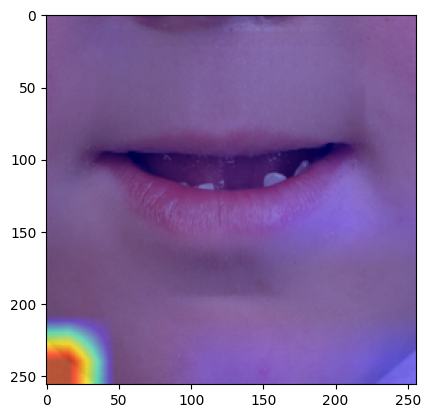

In [146]:
from pytorch_grad_cam import GradCAM, ScoreCAM, GradCAMPlusPlus, AblationCAM, XGradCAM, EigenCAM, FullGrad
from pytorch_grad_cam.utils.model_targets import ClassifierOutputTarget
from pytorch_grad_cam.utils.image import show_cam_on_image
from torchvision.models import resnet50



import torch
from torch.autograd import Variable
import torchvision.models as models
import cv2
import numpy as np

class Identity(nn.Module):
    def __init__(self):
        super(Identity, self).__init__()
        
    def forward(self, x):
        return x

class PretrainedNet(nn.Module):
    def __init__(self):
        super(PretrainedNet, self).__init__()
        self.cnn1 = torchvision.models.resnet18(pretrained = True)
        self.cnn1.fc = Identity()
        #for name, para in self.cnn1.named_parameters():
        #    if para.requires_grad:
        #        print (name)
        #alex_load.classifier[4] = nn.Linear(in_features = alex_load.classifier[1].out_features, out_features = 1000, bias = True)
        #self.cnn1.classifier[6] = nn.Linear(in_features = self.cnn1.classifier[4].out_features, out_features = 2, bias = True)
        
        
    def forward(self, x):
        output = self.cnn1(x)
        return output

    def forward_two(self, input1, input2):
        output1 = self.forward_once(input1)
        output2 = self.forward_once(input2)
        return output1, output2
#x = torch.randn(1, 3, 224, 224)
#output = vgg(x)
#print(output.shape)


checkpoints_dir = "./ckpt"
test_epoch = 15

#test_model = SiameseNetworkbasic().cuda()
test_model = PretrainedNet().cuda()
test_model.load_state_dict(torch.load(checkpoints_dir + "/base_model_epoch{}.pth".format(test_epoch)))
test_model.eval()
ctrLoss = ContrastiveLoss(margin = 2.0)
# Choose the layer from which you want to extract features
target_layer = [test_model.cnn1.layer4[-1].conv1]



truth_img_dir = '/mnt/recsys/daniel/simase_network/dataset_256_0_pct_all/data/truth'
out_img_dir = '/mnt/recsys/daniel/simase_network/dataset_256_0_pct_all/data/out'
image1_name = os.path.join(truth_img_dir, '2009_14_truth.png')
image2_name = os.path.join(out_img_dir, '2009_18_out.png')

rgb_img = np.array(Image.open(image2_name).convert("RGB"))/255.0
img1 = torch.unsqueeze(transform(Image.open(image1_name).convert("RGB")), dim = 0)
img2 = torch.unsqueeze(transform(Image.open(image2_name).convert("RGB")), dim = 0)

input_tensor = Variable(img2).cuda()
#output1,output2 = net(Variable(img1).cuda(),Variable(img2).cuda())




#input_tensor = # Create an input tensor image for your model..
# Note: input_tensor can be a batch tensor with several images!

# Construct the CAM object once, and then re-use it on many images:
cam = GradCAM(model=test_model, target_layers=target_layer, use_cuda=True)

# You can also use it within a with statement, to make sure it is freed,
# In case you need to re-create it inside an outer loop:
# with GradCAM(model=model, target_layers=target_layers, use_cuda=args.use_cuda) as cam:
#   ...

# We have to specify the target we want to generate
# the Class Activation Maps for.
# If targets is None, the highest scoring category
# will be used for every image in the batch.
# Here we use ClassifierOutputTarget, but you can define your own custom targets
# That are, for example, combinations of categories, or specific outputs in a non standard model.
targets = [ClassifierOutputTarget(0)]

# You can also pass aug_smooth=True and eigen_smooth=True, to apply smoothing.
grayscale_cam = cam(input_tensor=input_tensor, targets=targets)

# In this example grayscale_cam has only one image in the batch:
grayscale_cam = grayscale_cam[0, :]
visualization = show_cam_on_image(rgb_img, grayscale_cam, use_rgb=True)
plt.imshow(visualization)

In [2]:
class SiameseNetwork(nn.Module):
    def __init__(self):
        super(SiameseNetwork, self).__init__()
        self.cnn1 = nn.Sequential(
            nn.ReflectionPad2d(1),
            nn.Conv2d(1, 4, kernel_size=3),
            nn.ReLU(inplace=True),
            nn.BatchNorm2d(4),
            
            nn.ReflectionPad2d(1),
            nn.Conv2d(4, 8, kernel_size=3),
            nn.ReLU(inplace=True),
            nn.BatchNorm2d(8),


            nn.ReflectionPad2d(1),
            nn.Conv2d(8, 8, kernel_size=3),
            nn.ReLU(inplace=True),
            nn.BatchNorm2d(8),


        )

        self.fc1 = nn.Sequential(
            nn.Linear(8*100*100, 500),
            nn.ReLU(inplace=True),

            nn.Linear(500, 500),
            nn.ReLU(inplace=True),

            nn.Linear(500, 5))

    def forward_once(self, x):
        output = self.cnn1(x)
        output = output.view(output.size()[0], -1)
        output = self.fc1(output)
        return output

    def forward(self, input1, input2):
        output1 = self.forward_once(input1)
        output2 = self.forward_once(input2)
        return output1, output2

class SiameseNetworkbasic(nn.Module):
    def __init__(self):
        super(SiameseNetworkbasic, self).__init__()

        # Shared feature extraction layers (twin branches)
        self.cnn = nn.Sequential(
            nn.Conv2d(3, 32, 5),
            nn.ReLU(inplace=True),
            nn.Dropout(p=0.5),
            nn.MaxPool2d(2,2),
            
            nn.Conv2d(32, 64, 3),
            nn.ReLU(inplace=True),
            nn.Dropout(p=0.5),
            nn.MaxPool2d(2,2),
            
            nn.Conv2d(64, 64, 3),
            nn.ReLU(inplace=True),
            nn.Dropout(p=0.5),
            nn.MaxPool2d(2,2)
        )

        # Fully connected layers
        self.fc = nn.Sequential(
            nn.Linear(64*30*30, 1024),
            nn.ReLU(inplace=True),
            nn.Dropout(p=0.3),
            
            nn.Linear(1024, 256),
            nn.ReLU(inplace=True),
            nn.Dropout(p=0.3),
            
            nn.Linear(256, 2)  # 2 output dimensions for similarity scoring
        )
    
    
    def forward_one(self, x):
        # Forward pass through one branch of the Siamese network
        output = self.cnn(x)
        output = output.view(output.size()[0], -1)
        output = self.fc(output)
        return output

    def forward(self, input1, input2):
        # Forward pass through both branches
        output1 = self.forward_one(input1)
        output2 = self.forward_one(input2)
        return output1, output2

    
    

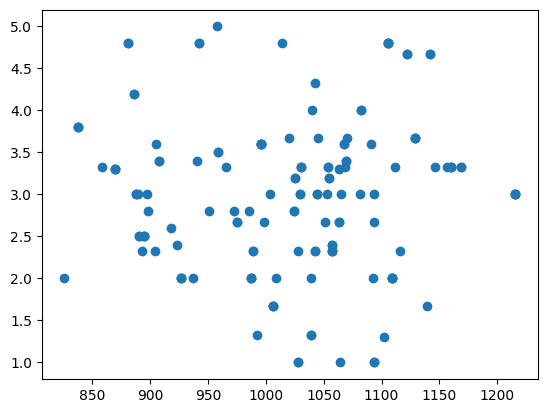

In [17]:
import matplotlib
matplotlib.pyplot.scatter(dissimilarity_score, scores_list)

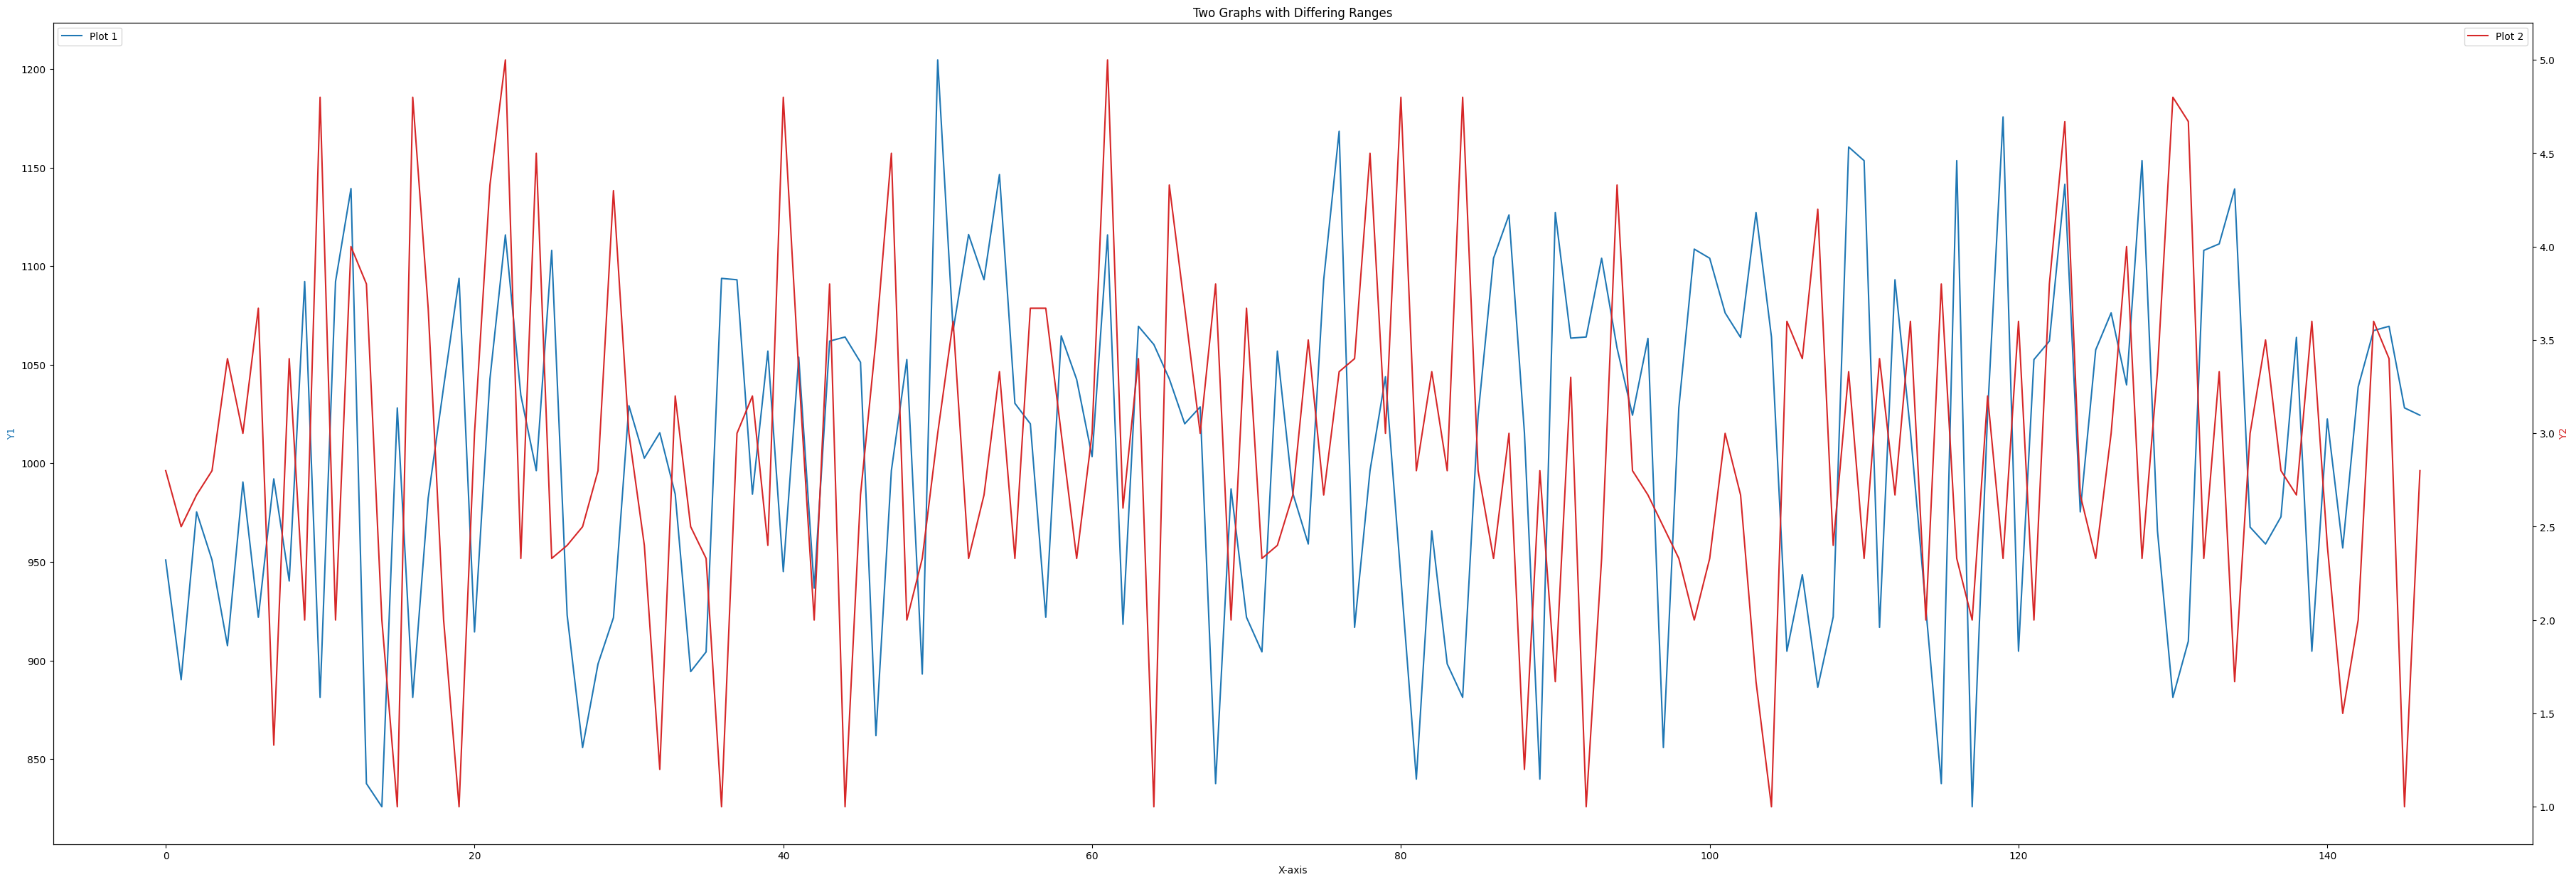

In [147]:
x1 = x_axis
y1 = dissimilarity_score

# Create example data for the second plot (plot2) with a different range
x2 = x1
y2 = scores_list  # Scaled for a different range

# Create a figure and the first set of axes

fig, ax1 = plt.subplots(figsize=(45, 15))
ax1.set_xlabel('X-axis')
ax1.set_ylabel('Y1', color='tab:blue')  # Label for the first plot

# Plot the first set of data on the first set of axes
ax1.plot(x1, y1, color='tab:blue', label='Plot 1')

# Create the second set of axes that shares the same x-axis
ax2 = ax1.twinx()
ax2.set_ylabel('Y2', color='tab:red')  # Label for the second plot

# Plot the second set of data on the second set of axes
ax2.plot(x2, y2, color='tab:red', label='Plot 2')

# Add legends for both plots
ax1.legend(loc='upper left')
ax2.legend(loc='upper right')

# Display the plots

plt.title('Two Graphs with Differing Ranges')
plt.show()


In [19]:

checkpoints_dir = "./ckpt"
test_epoch = 15

#test_model = SiameseNetworkbasic().cuda()
test_model = PretrainedNet().cuda()
test_model.load_state_dict(torch.load(checkpoints_dir + "/base_model_epoch{}.pth".format(test_epoch)))


test_transforms = transforms.Compose([ # pixel crop
    transforms.ToTensor()
])



testing_siamese_dataset = siamese_test_Dataset(patient_table = TestConfig.testing_table,
                                          image_dir = TestConfig.image_dir,
                                          scores_csv_file = TestConfig.scores_csv_file,
                                          transform = test_transforms)

test_dataloader = torch.utils.data.DataLoader(testing_siamese_dataset,
                                                  batch_size=1,
                                                  shuffle=True,
                                                  num_workers=0)

dataiter = iter(test_dataloader)

scores_list = []
dissimilarity_score = []
x_axis = [x for x in range(len(test_dataloader))]

print(len(test_dataloader))

for test_cnt in range(len(test_dataloader)):
    x_0, x_1, _ , score= next(dataiter)
    concatenated = torch.cat((x_0,x_1),0)
    output1,output2 = net(Variable(x_0).cuda(),Variable(x_1).cuda())
    euclidean_distance = F.pairwise_distance(output1, output2)
    scores_list.append(score.item())
    dissimilarity_score.append(euclidean_distance.item()*1000)
    #imshow(torchvision.utils.make_grid(concatenated),'Dissimilarity: {:.2f}_Score{:.2f}'.format(euclidean_distance.item()*1000,score.item() ))
    #print (euclidean_distance.item())
    

/mnt/recsys/daniel/anaconda3/envs/dani/lib/python3.9/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/mnt/recsys/daniel/anaconda3/envs/dani/lib/python3.9/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


NameError: name 'siamese_test_Dataset' is not defined

In [ ]:
# SHOULD OPEN SSH PORT 8050 ssh -fN cip -L 8050:localhost:8050 FOR DASH TO WORK


import io
import base64
import pandas as pd
from dash import Dash, dcc, html, Input, Output, no_update, callback
import plotly.express as px
import numpy as np
from PIL import Image

import plotly as py
import plotly.graph_objs as go
from plotly.offline import download_plotlyjs, init_notebook_mode, plot, iplot
from sklearn.cluster import AgglomerativeClustering



from sklearn.preprocessing import StandardScaler #used for 'Feature Scaling'
from sklearn.decomposition import PCA #Principal Component Analysis
from sklearn.manifold import TSNE #T-Distributed Stochastic Neighbor Embedding
from sklearn.cluster import KMeans 
from sklearn.cluster import AffinityPropagation


    
df = pd.DataFrame(dict( dice_val = dice_vals, symmetry_val = score_sym, filter_sym_val= symmetry_scores_filter, 
                       entropy_val = entropy_vals, gt_val = gt_scores_array, p_id = patient_ids, cond = condition_arr))


#features = df[["energy_val_red", "energy_val_green", "energy_val_blue", "dice_val", "symmetry_val", "filter_sym_val", "entropy_val"]]

#should test symmetry values without a ratio - direct symmetry value
features = df[["dice_val", "symmetry_val", "filter_sym_val", "entropy_val"]]




plotX = pd.DataFrame(np.array(kmeans_db))
pca_2d = PCA(n_components=2)


PCs_2d = pd.DataFrame(pca_2d.fit_transform(plotX.drop(["Cluster", "GT_vals", "ID", "condition"], axis=1)))
PCs_2d.columns = ["PC1_2d", "PC2_2d"]
plotX = pd.concat([plotX,PCs_2d], axis=1, join='inner')


cluster0 = plotX[plotX["Cluster"] == 0]
cluster1 = plotX[plotX["Cluster"] == 1]
cluster2 = plotX[plotX["Cluster"] == 2]

init_notebook_mode(connected=True)

trace1 = go.Scatter(
                    x = cluster0["PC1_2d"],
                    y = cluster0["PC2_2d"],
                    mode = "markers",
                    name = "cluster0",
                    marker = dict(color = 'rgba(255, 128, 255, 0.8)'),
                    ids = cluster0["ID"], 
                    text=cluster0["GT_vals"], 
                    hovertext= cluster0["condition"])

#trace2 is for 'Cluster 1'
trace2 = go.Scatter(
                    x = cluster1["PC1_2d"],
                    y = cluster1["PC2_2d"],
                    mode = "markers",
                    name = "cluster1",
                    marker = dict(color = 'rgba(255, 128, 2, 0.8)'),
                    ids = cluster1["ID"], 
                    text=cluster1["GT_vals"], 
                    hovertext= cluster1["condition"])

#trace3 is for 'Cluster 2'
trace3 = go.Scatter(
                    x = cluster2["PC1_2d"],
                    y = cluster2["PC2_2d"],
                    mode = "markers",
                    name = "cluster2",
                    marker = dict(color = 'rgba(0, 255, 200, 0.8)'),
                    ids = cluster2["ID"],
                    #marker = dict(size=4,line=dict(width=2, color='DarkSlateGrey')),
                    text=cluster2["GT_vals"], 
                    hovertext= cluster2["condition"])

data = [trace1, trace2, trace3]

title = "Visualizing Clusters in Two Dimensions Using PCA"

layout = dict(title = title,
              xaxis= dict(title= 'PC1',ticklen= 5,zeroline= False),
              yaxis= dict(title= 'PC2',ticklen= 5,zeroline= False)
             )

fig = dict(data = data, layout = layout)


# Set up the app now
app = Dash(__name__)

app.layout = html.Div(
    className="container",
    children=[
        dcc.Graph(id="graph-2-dcc", figure=fig, clear_on_unhover=True),
        dcc.Tooltip(id="graph-tooltip-2", direction='bottom'),
    ],
)

@callback(
    Output("graph-tooltip-2", "show"),
    Output("graph-tooltip-2", "bbox"),
    Output("graph-tooltip-2", "children"),
    Output("graph-tooltip-2", "direction"),

    Input("graph-2-dcc", "hoverData"),
)
def display_hover(hoverData):
    if hoverData is None:
        return False, no_update, no_update, no_update
    #print (hoverData["points"][0] )
    img_name = hoverData["points"][0]["id"]
    vals = hoverData["points"][0]["text"]
    condition = hoverData["points"][0]["hovertext"]
    
    
    # Load image with pillow
    image_path = '/mnt/recsys/daniel/datasets/testing_cleft/original_img_mask/ori_img/'+ img_name +'.png'
    im = Image.open(image_path).convert('RGB')

    # dump it to base64
    buffer = io.BytesIO()
    im.save(buffer, format="jpeg")
    encoded_image = base64.b64encode(buffer.getvalue()).decode()
    im_url = "data:image/jpeg;base64, " + encoded_image

    # demo only shows the first point, but other points may also be available
    hover_data = hoverData["points"][0]
    bbox = hover_data["bbox"]
    

    # control the position of the tooltip
    y = hover_data["y"]
    direction = "bottom" if y > 1.5 else "top"

    children = [
        html.Img(
            src=im_url,
            style={"width": "200px"},
        ),
        html.P(img_name + " " + condition + " " + vals),
    ]
    
    return True, bbox, children, direction

if __name__ == "__main__":
    app.run(debug=True)

In [26]:
TestConfig.scores_csv_file[1:10]

,Patient number,Lip Score
1,2012_10,4.67
2,2012_11,1.67
3,2012_12,2.33
4,2012_13,1.67
5,2012_14,3.33
6,2012_15,1.67
7,2012_16,2.00
8,2012_17,3.00
9,2012_18,4.00


In [10]:
counter

[0, 1, 2, 3, 4, 5, 6, 7, 8, 9]

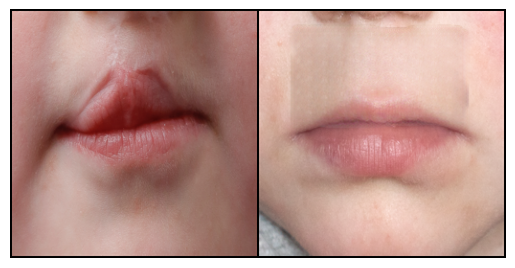

[1]


In [11]:
#visualizing inputs


vis_dataloader = torch.utils.data.DataLoader(testing_siamese_dataset,
                                                  batch_size=1,
                                                  shuffle=True,
                                                  num_workers=0)



dataiter = iter(vis_dataloader)
example_batch = next(dataiter)
concatenated = torch.cat((example_batch[0],example_batch[1]),0)
imshow(torchvision.utils.make_grid(concatenated))
print(example_batch[2].numpy())

In [12]:
example_batch[1].shape

torch.Size([1, 3, 256, 256])

In [32]:
from torchvision import transforms, models

class SiameseAlexnet(nn.Module):
    """
    Siamese neural network
    Modified from: https://hackernoon.com/facial-similarity-with-siamese-networks-in-pytorch-9642aa9db2f7
    Siamese ResNet-101 from Pytorch library
    """
    def __init__(self):
        super(SiameseAlexnet, self).__init__()
        # note that resnet101 requires 3 input channels, will repeat grayscale image x3
        #self.cnn1 = models.resnet101(pretrained = True)
        self.cnn1 = models.alexnet(pretrained = True)
        #for param in self.cnn1.parameters():
        #    param.requires_grad = False
        #self.cnn1.fc = nn.Linear(2048, 512) # mapping input image to a 3 node output
        for name, para in self.cnn1.named_parameters():
            if para.requires_grad:
                print (name)

    def forward_once(self, x):
        output = self.cnn1(x)
        return output

    def forward(self, input1, input2):
        output1 = self.forward_once(input1)
        output2 = self.forward_once(input2)
        return output1, output2

    
alex = SiameseAlexnet()

ValueError: The parameter 'num_classes' expected value 1000 but got 2 instead.

In [31]:
#prints output of every layer in the network


def print_layer_output_sizes(model, input_size):
    def forward_hook(module, input, output):
        print(f"Layer: {module.__class__.__name__}")
        print(f"Input size: {str(input[0].shape)}")
        print(f"Output size: {str(output.shape)}")
        print("------------------")

    hooks = []
    for name, layer in model.named_children():
        hook = layer.register_forward_hook(forward_hook)
        hooks.append(hook)

    # Put the model in evaluation mode
    model.eval()

    # Perform a forward pass with a dummy input to trigger the hooks
    with torch.no_grad():
        model(input_size, input_size)

    # Remove the hooks
    for hook in hooks:
        hook.remove()

alex = SiameseAlexnet()
input_tensor1 = torch.randn(1, 3, 256, 256)  # Adjust input size as needed
#input_tensor2 = torch.randn(1, 3, 224, 224)
# Print the output sizes
print_layer_output_sizes(alex, input_tensor1)

features.0.weight
features.0.bias
features.3.weight
features.3.bias
features.6.weight
features.6.bias
features.8.weight
features.8.bias
features.10.weight
features.10.bias
classifier.1.weight
classifier.1.bias
classifier.4.weight
classifier.4.bias
classifier.6.weight
classifier.6.bias
Layer: AlexNet
Input size: torch.Size([1, 3, 256, 256])
Output size: torch.Size([1, 1000])
------------------
Layer: AlexNet
Input size: torch.Size([1, 3, 256, 256])
Output size: torch.Size([1, 1000])
------------------


In [ ]:
class siamese_Dataset(torch.utils.data.Dataset):
    """
    Create dataset representation of ROP data
    - This class returns image pairs with a change label (i.e. change vs no change in a categorical disease severity label) and other metadata
    - Image pairs are sampled so that there are an equal number of change vs no change labels
    - Epoch size can be set for empirical testing

    Concepts adapted from:
    - https://hackernoon.com/facial-similarity-with-siamese-networks-in-pytorch-9642aa9db2f7
    - https://pytorch.org/tutorials/beginner/data_loading_tutorial.html
    """
    def __init__(self, patient_table, image_dir, mode, transform=None):
        """
        Args:
            patient_table (pd.dataframe): dataframe table containing image names, disease severity category label, and other metadata
            image_dir (string): directory containing all of the image files
            transform (callable, optional): optional transform to be applied on a sample
        """
        self.patient_table = patient_table
        self.image_dir = image_dir
        self.transform = transform
        self.epoch_size = len(self.patient_table)
        self.mode = mode
        if self.transform is None:
            self.transform = transforms.Compose([transforms.ToTensor()])

    def __len__(self):
        return self.epoch_size

    def __getitem__(self, idx):
        #you should change this part-------------------------------------------------------------------
        name_list = self.patient_table
        num_entries = len(name_list)
        # goal is 50:50 distribution of change vs no change
        change_binary = random.randint(0,1)
        label = None
        # keep on looping until no change pair created
        while change_binary == 0:

            while True:
                #random_image = random.choice(name_list).split('.')[0]+'.png' # note that processed images are all .png type, while patient_table has different types

                random_num = randint(0, num_entries-1)
                #random_image_row = random.choice(name_list)

                random_image_row = name_list.iloc[random_num]
                random_image = random_image_row['File_name']
                #if random_image in os.listdir(os.path.join(self.image_dir, self.mode, random_image_row['class'])):

                paired_image = random_image.split(".")[0][:-5] + 'out.png'
                #print (random_image ,"\n", paired_image)
                if (random_image in os.listdir(os.path.join(self.image_dir, self.mode, "truth"))) and (paired_image in os.listdir(os.path.join(self.image_dir, self.mode,  "out"))):
                    break
                elif paired_image in os.listdir(os.path.join(self.image_dir, self.mode,  "out")):
                    print('attempted to get following image, but missing: ' + random_image)
                elif random_image in os.listdir(os.path.join(self.image_dir, self.mode, "truth")):
                    print('attempted to get following image, but missing: ' + paired_image)

            img_name1 = random_image.split('.')[0].split('_')[:2]
            img_name2 = paired_image.split('.')[0].split('_')[:2]

            if img_name1 == img_name2:
                label = 0
                break

        # keep on looping until change pair created
        while change_binary == 1:

            # pick random image from folder
            # check to see if the image exists and can be loaded, if not move to another random image
            while True:

                random_num = randint(0, num_entries - 1)
                pair_num = randint(0, num_entries - 1)
                if random_num == pair_num:
                    continue

                # random_image_row = random.choice(name_list)

                random_image_row = name_list.iloc[random_num]
                random_image = random_image_row['File_name']

                paired_image_row = name_list.iloc[pair_num]
                paired_image = paired_image_row['File_name'].split(".")[0][:-5] + 'out.png'
                
                print (random_image ,"\n", paired_image)
                if (random_image in os.listdir(os.path.join(self.image_dir, self.mode, "truth"))) and (paired_image in os.listdir(os.path.join(self.image_dir, self.mode, "out"))):
                    break
                elif paired_image in os.listdir(os.path.join(self.image_dir, self.mode,  "out")):
                    print('attempted to get following image, but missing: ' + random_image)
                elif random_image in os.listdir(os.path.join(self.image_dir,  self.mode, "truth")):
                    print('attempted to get following image, but missing: ' + paired_image)

            img_name1 = random_image.split('.')[0].split('_')[:2]
            img_name2 = paired_image.split('.')[0].split('_')[:2]

            if img_name1 != img_name2:
                label = 1
                break

        random_img_dir = os.path.join(self.image_dir,  self.mode, "truth")
        paired_img_dir = os.path.join(self.image_dir,  self.mode, "out")
        img0 = Image.open(random_img_dir +'/' +random_image).convert("RGB")
        img1 = Image.open(paired_img_dir +'/' +paired_image).convert("RGB")

        #img0 = img0.convert("L")            #converting to grayscale
        #img1 = img1.convert("L")            #converting to grayscale
        k1, k2 = img0.size, img1.size
        if self.transform is not None:
            img0 = self.transform(img0)
            img1 = self.transform(img1)
        #print ('bhghjagfhafgdhsfgdhjgfhghghjfgdhjg',img0.shape)
        return img0, img1, label

